In [1]:
import math
import torch
from torch import Tensor

# GMM implementation from scratch
### GMM class definition
    - n_components: number of mixture components
    - max_iter: max EM iterations
    - tol: convergence tolerance on log likelihood improvement
    - reg_covar: added to diagonal of covariance matrices for numeric stability
    - init_params: 'kmeans' or 'random'
    - fitted parameters: weights_, means_, covariances_
### methods
    - _init_params
    - _estimate_log_gaussian_prob (P(x|\mu_k,\Sigma_k)
    - _e_step
    - _m_step
    - fit (alternate e-step and m-step until convergence)
    - predict_proba (compute responsibilities)
    - predict (hard cluster assignment)
    - sample (from a fitted mixture)

In [2]:
class GMM:
    """
    Gaussian Mixture Model (EM) with full covariance matrices, implemented in PyTorch.
    - n_components: number of mixture components
    - max_iter: max EM iterations
    - tol: convergence tolerance on log likelihood improvement
    - reg_covar: added to diagonal of covariance matrices for numeric stability
    - init_params: 'kmeans' or 'random'
    """

    def __init__(self, n_components=3, max_iter=200, tol=1e-4, reg_covar=1e-6, init_params='kmeans', device=None, dtype=torch.float32):
        self.n_components = int(n_components)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.reg_covar = float(reg_covar)
        assert init_params in ('kmeans', 'random')
        self.init_params = init_params
        self.device = device or torch.device('cpu')
        self.dtype = dtype

        # fitted parameters (will be set in fit)
        self.weights_ = None    # (K,)
        self.means_ = None      # (K, D)
        self.covariances_ = None # (K, D, D)

    def _check_X(self, X):
        if not torch.is_tensor(X):
            X = torch.tensor(X, dtype=self.dtype, device=self.device)
        else:
            X = X.to(device=self.device, dtype=self.dtype)
        assert X.dim() == 2, "X should be 2D (N, D)"
        return X

    # ----- initialization (kmeans-like) -----
    def _init_params(self, X):
        N, D = X.shape
        K = self.n_components

        if self.init_params == 'random':
            # random pick means from data
            ids = torch.randperm(N, device=self.device)[:K]
            means = X[ids].clone()
        else:
            # simple kmeans++ initialization (not full kmeans iterations, but good seeds)
            means = torch.empty((K, D), dtype=self.dtype, device=self.device)
            ids = torch.randperm(N, device=self.device)
            means[0] = X[ids[0]]
            # distances for each point to nearest center
            dist = torch.full((N,), float('inf'), device=self.device, dtype=self.dtype)
            for k in range(1, K):
                d = torch.sum((X - means[k-1])**2, dim=1)
                dist = torch.minimum(dist, d)
                # probability proportional to dist
                probs = dist / torch.sum(dist)
                # sample next center
                idx = torch.multinomial(probs, 1).item()
                means[k] = X[idx]

        # initial covariances: empirical covariance of X plus reg, assign identical to all
        emp_cov = self._empirical_covariance(X, X.mean(dim=0))
        covariances = emp_cov.unsqueeze(0).repeat(K, 1, 1)  # (K, D, D)
        covariances += torch.eye(D, device=self.device, dtype=self.dtype).unsqueeze(0) * self.reg_covar

        weights = torch.full((K,), 1.0 / K, dtype=self.dtype, device=self.device)
        self.means_ = means
        self.covariances_ = covariances
        self.weights_ = weights

    @staticmethod
    def _empirical_covariance(X, mean):
        # unbiased estimator / N (we'll use ML estimator dividing by N)
        Xc = X - mean
        cov = (Xc.t() @ Xc) / X.shape[0]
        return cov

    # ----- logpdf computation (stable) -----
    def _estimate_log_gaussian_prob(self, X):
        """
        Compute log N(x | mu_k, Sigma_k) for all k and x.
        Returns shape (N, K)
        Uses Cholesky-based stable computation of logpdf.
        """
        N, D = X.shape
        K = self.n_components
        log_probs = torch.empty((N, K), dtype=self.dtype, device=self.device)

        for k in range(K):
            mu = self.means_[k]               # (D,)
            cov = self.covariances_[k]        # (D, D)
            # ensure symmetric and add reg_covar
            cov = (cov + cov.t()) / 2.0
            cov = cov + torch.eye(D, device=self.device, dtype=self.dtype) * self.reg_covar

            # Cholesky decomposition of cov: cov = L L^T
            try:
                L = torch.linalg.cholesky(cov)  # lower-triangular
            except RuntimeError as e:
                # fallback: add more regularization if cholesky fails
                jitter = self.reg_covar * 10
                L = torch.linalg.cholesky(cov + torch.eye(D, device=self.device, dtype=self.dtype) * jitter)

            # compute log |cov| = 2 * sum(log(diag(L)))
            log_det = 2.0 * torch.sum(torch.log(torch.diagonal(L)))
            # solve for y = L^{-1} (x - mu)
            xm = X - mu.unsqueeze(0)  # (N, D)
            # solve triangular system: for each row
            # use torch.triangular_solve or torch.linalg.solve (more modern)
            # solve L y = xm^T  => y = L^{-1} xm^T
            y = torch.linalg.solve(L, xm.t())  # (D, N)
            quad = torch.sum(y**2, dim=0)      # (N,)
            # log gaussian
            const = -0.5 * (D * math.log(2 * math.pi))
            log_probs[:, k] = const - 0.5 * log_det - 0.5 * quad
        return log_probs  # (N, K)

    # ----- E-step: responsibilities and log likelihood -----
    def _e_step(self, X):
        """
        Returns:
          - log_resp: (N, K) log responsibilities
          - resp: (N, K) responsibilities
          - log_likelihood: scalar
        """
        N, D = X.shape
        log_gauss = self._estimate_log_gaussian_prob(X)  # (N, K)
        log_weights = torch.log(self.weights_.clamp(min=1e-30))  # (K,)
        log_prob = log_gauss + log_weights.unsqueeze(0)  # (N, K)

        # log-sum-exp over components to get per-sample normalizer
        max_log = torch.max(log_prob, dim=1, keepdim=True).values  # (N,1)
        lse = max_log + torch.log(torch.sum(torch.exp(log_prob - max_log), dim=1, keepdim=True))  # (N,1)
        log_resp = log_prob - lse  # normalized log responsibilities (N,K)
        resp = torch.exp(log_resp)

        # total log-likelihood is sum of lse
        log_likelihood = torch.sum(lse).item()
        return log_resp, resp, log_likelihood

    # ----- M-step: update params given responsibilities -----
    def _m_step(self, X, resp):
        N, D = X.shape
        K = self.n_components

        # effective number of points per component
        nk = resp.sum(dim=0) + 1e-10  # (K,)
        weights = nk / N              # (K,)

        # update means
        means = (resp.t() @ X) / nk.unsqueeze(1)  # (K, D)

        # update covariances
        covariances = torch.empty((K, D, D), dtype=self.dtype, device=self.device)
        for k in range(K):
            Xm = X - means[k].unsqueeze(0)  # (N, D)
            # weighted covariance (ML estimator dividing by nk[k])
            wk = resp[:, k].unsqueeze(1)  # (N, 1)
            cov = (Xm * wk).t() @ Xm / nk[k]
            # symmetric and regularize
            cov = (cov + cov.t()) / 2.0
            cov += torch.eye(D, device=self.device, dtype=self.dtype) * self.reg_covar
            covariances[k] = cov

        self.weights_ = weights
        self.means_ = means
        self.covariances_ = covariances

    # ----- main fit -----
    def fit(self, X, verbose=False):
        """
        Fit the GMM to X using EM.
        X: array-like (N, D) or torch tensor
        """
        X = self._check_X(X)
        N, D = X.shape
        self._init_params(X)

        prev_log_likelihood = -float('inf')
        for i in range(self.max_iter):
            log_resp, resp, log_likelihood = self._e_step(X)
            self._m_step(X, resp)
            improvement = log_likelihood - prev_log_likelihood
            if verbose:
                print(f"Iter {i:3d}  log-likelihood: {log_likelihood:.6f}  improvement: {improvement:.6f}")
            if abs(improvement) < self.tol:
                break
            prev_log_likelihood = log_likelihood
        return self

    # ----- responsibilities and predictions -----
    def predict_proba(self, X):
        X = self._check_X(X)
        log_gauss = self._estimate_log_gaussian_prob(X)
        log_weights = torch.log(self.weights_.clamp(min=1e-30))
        log_prob = log_gauss + log_weights.unsqueeze(0)
        # normalise
        max_log = torch.max(log_prob, dim=1, keepdim=True).values
        lse = max_log + torch.log(torch.sum(torch.exp(log_prob - max_log), dim=1, keepdim=True))
        log_resp = log_prob - lse
        return torch.exp(log_resp)  # (N, K)

    def score_samples(self, X):
        """Return per-sample log-likelihoods (log p(x))."""
        X = self._check_X(X)
        log_gauss = self._estimate_log_gaussian_prob(X)
        log_weights = torch.log(self.weights_.clamp(min=1e-30))
        log_prob = log_gauss + log_weights.unsqueeze(0)
        # log-sum-exp across components
        max_log = torch.max(log_prob, dim=1, keepdim=True).values
        lse = max_log + torch.log(torch.sum(torch.exp(log_prob - max_log), dim=1, keepdim=True))
        return lse.squeeze(1)  # (N,)

    def predict(self, X):
        """Return component labels (hard assignment)"""
        proba = self.predict_proba(X)
        return torch.argmax(proba, dim=1)

    # ----- sampling from fitted mixture -----
    def sample(self, n_samples=1):
        if self.weights_ is None:
            raise ValueError("Model not fitted yet")
        K, D = self.means_.shape
        # choose components
        comp_idx = torch.multinomial(self.weights_, n_samples, replacement=True)
        samples = torch.empty((n_samples, D), dtype=self.dtype, device=self.device)
        for i in range(n_samples):
            k = comp_idx[i].item()
            mu = self.means_[k]
            cov = self.covariances_[k]
            # sample from multivariate normal via cholesky
            L = torch.linalg.cholesky(cov)
            z = torch.randn(D, dtype=self.dtype, device=self.device)
            samples[i] = mu + (L @ z)
        return samples, comp_idx

    # ----- utility: get params as numpy for inspection -----
    def get_params(self):
        return {
            'weights': self.weights_.cpu().numpy(),
            'means': self.means_.cpu().numpy(),
            'covariances': self.covariances_.cpu().numpy()
        }


# Test the GMM implementation

In [3]:
torch.manual_seed(0)

# generate synthetic 2D data: 3 clusters
N = 900
mus = torch.tensor([[0., 0.], [5., 5.], [-5., 4.]])
covs = torch.stack([torch.eye(2)*0.5, torch.tensor([[1.0, 0.3],[0.3, 0.5]]), torch.tensor([[0.7, -0.2],[-0.2, 0.6]])])
weights = torch.tensor([0.3, 0.5, 0.2])

X = []
for k in range(3):
    nk = int(N * weights[k].item())
    L = torch.linalg.cholesky(covs[k])
    z = torch.randn(nk, 2)
    Xk = mus[k] + (z @ L.t())
    X.append(Xk)
X = torch.vstack(X)

# fit GMM
model = GMM(n_components=3, max_iter=200, tol=1e-5, reg_covar=1e-6)
model.fit(X, verbose=True)

print("Fitted weights:", model.weights_)
print("Fitted means:", model.means_)
# check predicted labels
labels = model.predict(X)
print("Counts per predicted cluster:", torch.bincount(labels))


Iter   0  log-likelihood: -4537.926270  improvement: inf
Iter   1  log-likelihood: -3633.663086  improvement: 904.263184
Iter   2  log-likelihood: -3118.472168  improvement: 515.190918
Iter   3  log-likelihood: -3017.172363  improvement: 101.299805
Iter   4  log-likelihood: -3016.497070  improvement: 0.675293
Iter   5  log-likelihood: -3016.478760  improvement: 0.018311
Iter   6  log-likelihood: -3016.477539  improvement: 0.001221
Iter   7  log-likelihood: -3016.477783  improvement: -0.000244
Iter   8  log-likelihood: -3016.477539  improvement: 0.000244
Iter   9  log-likelihood: -3016.477783  improvement: -0.000244
Iter  10  log-likelihood: -3016.477783  improvement: 0.000000
Fitted weights: tensor([0.5006, 0.2994, 0.2000])
Fitted means: tensor([[ 4.9458,  5.0287],
        [ 0.0800,  0.0122],
        [-4.9737,  3.9175]])
Counts per predicted cluster: tensor([451, 269, 180])


# GMMs on MNIST
- Loading MNIST
- Flattening images into 784-dim vectors
-  PCA for dimensionality reduction (GMM in 784 dimensions is very slow)
- Evaluating cluster assignments vs. true MNIST labels
- Visualize cluster means

In [4]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load MNIST data

In [5]:
def load_mnist():
    transform = transforms.ToTensor()
    train = MNIST(root="./data", train=True, download=True, transform=transform)
    test = MNIST(root="./data", train=False, download=True, transform=transform)
    X_train = train.data.numpy().reshape(-1, 28*28).astype(float)
    X_test = test.data.numpy().reshape(-1, 28*28).astype(float)
    y_train = train.targets.numpy()
    y_test = test.targets.numpy()
    print("Train shape:", X_train.shape)
    print("Test shape:",  X_test.shape)
    return X_train, y_train, X_test, y_test

# Reduce dimensionality via PCA
- PCA to D dimensions (50, initially)

In [10]:
def reduce_dimensionality(X_train, X_test, n_components=50):
    pca = PCA(n_components=n_components, whiten=True)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("After PCA train set dim:", X_train_pca.shape)
    print("After PCA test set dim:", X_test_pca.shape)
    return X_train_pca, X_test_pca, pca


# Fit the GMM
- use sklearn GaussianMixture

In [6]:
def fit_gmm(X_train_pca, n_components=10,covariance_type='full',tol=1e-6,reg_covar=1e-6,
            max_iter=100,n_init=1,init_params='kmeans',random_state=0):
    gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            tol=tol, reg_covar=reg_covar,
            max_iter=max_iter,n_init=n_init,init_params=init_params,
            random_state=random_state,
            )

    gmm.fit(X_train_pca)
    return gmm

# Visualize cluster means

In [7]:
def visualize_cluster_means(gmm, pca, n_cols=5):
    means_pca = gmm.means_
    means_img = pca.inverse_transform(means_pca).reshape(-1, 28, 28)

    n = means_img.shape[0]
    n_rows = int(np.ceil(n / n_cols))
    plt.figure(figsize=(12, 6))

    for i in range(n):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(means_img[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Cluster {i}")
    plt.tight_layout()
    plt.show()

# Conditional sampling from a GMM

In [8]:
def sample_from_cluster(gmm, pca, cluster_id, n_samples=10):
    mean = gmm.means_[cluster_id]
    cov = gmm.covariances_[cluster_id]
    samples = np.random.multivariate_normal(mean, cov, size=n_samples)
    imgs = pca.inverse_transform(samples).reshape(-1, 28, 28)


    plt.figure(figsize=(10, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(imgs[i], cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Samples from GMM cluster {cluster_id}")
    plt.show()

Loading MNIST...
Train shape: (60000, 784)
Test shape: (10000, 784)
Applying PCA...
After PCA train set dim: (60000, 50)
After PCA test set dim: (10000, 50)
Fitting GMM...


C:\Users\veron\anaconda3\Lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Predicting clusters...
Visualizing cluster means...


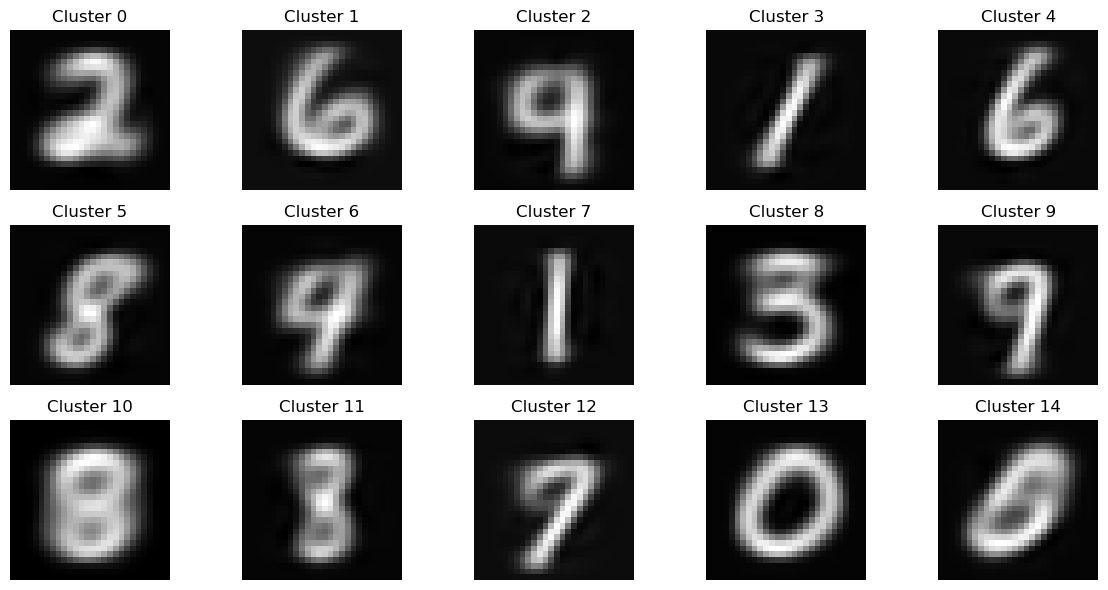

Sampling from cluster 1...


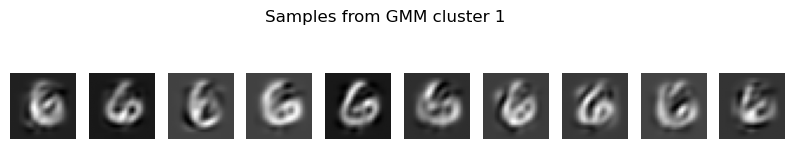

In [11]:
print("Loading MNIST...")
X_train, y_train, X_test, y_test = load_mnist()

print("Applying PCA...")
X_train_pca, X_test_pca, pca = reduce_dimensionality(X_train, X_test)


print("Fitting GMM...")
gmm = fit_gmm(X_train_pca,n_components=15)


print("Predicting clusters...")
clusters_train = gmm.predict(X_train_pca)
clusters_test = gmm.predict(X_test_pca)

print("Visualizing cluster means...")
visualize_cluster_means(gmm, pca)

print("Sampling from cluster 1...")
sample_from_cluster(gmm, pca, cluster_id=1)


# Exploration of Key Hyperparameters & choices for GMM fits

- Pipeline
    - Load MNIST, standardize (zero mean, unit variance).
    - PCA -- choose d (50 or 100). Choose whiten=True. Try both values, and select best.
    - Grid-search GMM: see list of parameters below.
    - Evaluate with BIC/AIC, log_likelihood; inspect cluster means  
    - Once best params found, refit on full training set.
- Grid search parameters
  - n_components in [10,20,30,50,100]
  - covariance_type in ['diag','full','tied']
  - n_init = [5,10,15,20]
  - max_iter = 300
  - tol=1e-4 (monitor log-likelihood; increase max_iter for larger n_components)
  - init_params = kmeans++
  - reg_covar = 1e-6 --- increase if needed to 1e-4 or 1e-3 if you get singular matrix errors

Show your code for finding the best GMM hyperparameters for MNIST and show the loglikelihood achieved, BIC/AIC scores and visualize the cluster means for your best hyperparameters. Leave all your plots/visualizations in place.

- Discuss your results,  interpret the clusters and reflect on EM's behavior as the number of components increases.

# Your code here

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

print("Loading MNIST...")
X_train, y_train, X_test, y_test = load_mnist()

# 1) Standardize to zero mean, unit variance
print("Standardizing data (zero mean, unit variance)...")
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# 2) Define search space
pca_dims = [50, 100]
n_components_list = [10, 20, 30, 50, 100]
covariance_types = ['diag', 'full', 'tied']
n_init_list = [5, 10, 15, 20]

tol = 1e-4
max_iter = 300
reg_covar = 1e-4
init_params = 'k-means++'
random_state = 0

results = []
best_bic = np.inf
best_model = None

# 3) Grid search over PCA dimension + GMM hyperparameters
for d in pca_dims:
    print(f"\n=== PCA dimension d = {d} ===")
    X_train_pca, X_test_pca, pca = reduce_dimensionality(
        X_train_std, X_test_std, n_components=d)

    for n_components in n_components_list:
        for cov_type in covariance_types:
            for n_init in n_init_list:
                print(f"Fitting GMM: K={n_components}, cov={cov_type}, n_init={n_init}")
                try:
                    gmm = fit_gmm(
                        X_train_pca,
                        n_components=n_components,
                        covariance_type=cov_type,
                        tol=tol,
                        reg_covar=reg_covar,
                        max_iter=max_iter,
                        n_init=n_init,
                        init_params=init_params,
                        random_state=random_state)
                except Exception as e:
                    print("Failed with error:", e)
                    continue

                avg_log_lik = gmm.score(X_train_pca)
                total_log_lik = avg_log_lik * X_train_pca.shape[0]
                aic = gmm.aic(X_train_pca)
                bic = gmm.bic(X_train_pca)

                print(f"avg log-lik: {avg_log_lik:.4f}, AIC: {aic:.2f}, BIC: {bic:.2f}")

                cfg = {
                    "pca_dim": d,
                    "n_components": n_components,
                    "covariance_type": cov_type,
                    "n_init": n_init,
                    "avg_log_likelihood": avg_log_lik,
                    "total_log_likelihood": total_log_lik,
                    "aic": aic,
                    "bic": bic}
                results.append(cfg)

                if bic < best_bic:
                    best_bic = bic
                    best_model = {
                        "config": cfg,
                        "gmm": gmm,
                        "pca": pca,
                        "X_train_pca": X_train_pca,
                        "X_test_pca": X_test_pca}

                    print("New best model so far (lowest BIC).")

# 4) Summarize grid-search results
results_df = pd.DataFrame(results).sort_values("bic").reset_index(drop=True)
print("\nTop 10 models (sorted by BIC):")
print(results_df.head(10))

print("\nBest model hyperparameters (by BIC):")
print(best_model["config"])

# 5) Compute final metrics for the best model
gmm_best = best_model["gmm"]
pca_best = best_model["pca"]
X_train_pca_best = best_model["X_train_pca"]

avg_log_lik_best = gmm_best.score(X_train_pca_best)
total_log_lik_best = avg_log_lik_best * X_train_pca_best.shape[0]
aic_best = gmm_best.aic(X_train_pca_best)
bic_best = gmm_best.bic(X_train_pca_best)

print("\nBest model scores on training set:")
print(f"Avg log-likelihood per sample: {avg_log_lik_best:.4f}")
print(f"Total log-likelihood: {total_log_lik_best:.2f}")
print(f"AIC: {aic_best:.2f}")
print(f"BIC: {bic_best:.2f}")

# 6) Visualize cluster means for the best hyperparameters
print("\nVisualizing cluster means for best model...")
visualize_cluster_means(gmm_best, pca_best)

Loading MNIST...
Train shape: (60000, 784)
Test shape: (10000, 784)
Standardizing data (zero mean, unit variance)...

=== PCA dimension d = 50 ===
After PCA train set dim: (60000, 50)
After PCA test set dim: (10000, 50)
Fitting GMM: K=10, cov=diag, n_init=5
avg log-lik: -56.5206, AIC: 6784489.83, BIC: 6793572.95
New best model so far (lowest BIC).
Fitting GMM: K=10, cov=diag, n_init=10
